# Diversity

For this experiment, we will want to find multiple different levels with the same difficulty.

In [1]:
import matplotlib.pyplot as plt
import torch
from IPython.core.display import clear_output
from matplotlib import cm
from torch.nn import LeakyReLU, functional as F
from torch.optim import Adam

from evaluators import DirectEvaluator
from helpers import set_matplotlib_colors
from shared_parameters import *
from utils import MLP

torch.set_printoptions(linewidth=120, sci_mode=False)

Let's see how this looks (as an interactive 3d plot)

tensor([[-0.5116, -0.4005, -0.2894, -0.1783, -0.0672,  0.0439,  0.1550,  0.2662,  0.3773,  0.4884],
        [-0.5116, -0.4005, -0.2894, -0.1783, -0.0672,  0.0439,  0.1550,  0.2662,  0.3773,  0.4884],
        [-0.5116, -0.4005, -0.2894, -0.1783, -0.0672,  0.0439,  0.1550,  0.2662,  0.3773,  0.4884],
        [-0.5116, -0.4005, -0.2894, -0.1783, -0.0672,  0.0439,  0.1550,  0.2661,  0.3773,  0.4884],
        [-0.5116, -0.4005, -0.2894, -0.1783, -0.0672,  0.0439,  0.1550,  0.2661,  0.3773,  0.4884],
        [-0.5116, -0.4005, -0.2894, -0.1783, -0.0672,  0.0439,  0.1550,  0.2661,  0.3773,  0.4884],
        [-0.5116, -0.4005, -0.2894, -0.1783, -0.0672,  0.0439,  0.1550,  0.2661,  0.3773,  0.4884],
        [-0.5116, -0.4005, -0.2894, -0.1783, -0.0672,  0.0439,  0.1550,  0.2661,  0.3772,  0.4884],
        [-0.5116, -0.4005, -0.2894, -0.1783, -0.0672,  0.0439,  0.1550,  0.2661,  0.3772,  0.4884],
        [-0.5116, -0.4005, -0.2894, -0.1783, -0.0672,  0.0439,  0.1550,  0.2661,  0.3772,  0.4884]])

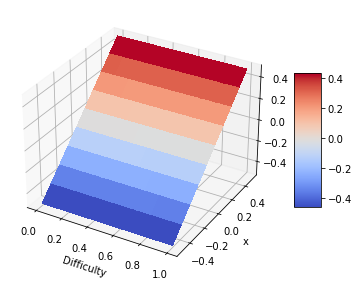

In [3]:
oracle = DirectEvaluator(connector_length, max_angle, enemy_radius, bob_radius)
generator = MLP(1, 2, hidden=[2, 2], activation=LeakyReLU())
optim_generator = Adam(generator.parameters(), lr=0.001)

num_difficulties = 100

# Our dataset of [difficulty, seed] inputs
difficulties = torch.linspace(0, 1, num_difficulties)

iteration = 0
loss_evaluator = float("inf")
def iterate(verbose=False):
    global difficulties, iteration
    indices = torch.randperm(difficulties.shape[0])[:15]
    inputs = difficulties[indices]

    states = generator(inputs)
    d_out = oracle(states)

    d_in = inputs[:, 0:1]
    _seeds = inputs[:, 1:]

    seeds_difference = torch.norm(_seeds.unsqueeze(0) - _seeds.unsqueeze(1), dim=-1)
    states_difference = torch.norm(states.unsqueeze(0) - states.unsqueeze(1), dim=-1)

    difference = (seeds_difference * states_difference).mean() / 2

    loss_generator = F.l1_loss(d_in, d_out)
    loss = loss_generator - 0.15 * difference

    # Update the generator
    optim_generator.zero_grad()
    loss.backward()
    optim_generator.step()

    iteration += 1

    if verbose:
        clear_output(wait=True)
        print(f"It.: {iteration}, "
              f"(G) {loss_generator.item():.5f} "
              f"(diff) {difference.item():.5f}")

        print("Parameters:")
        for p in generator.parameters():
            print(p.data)


        difficulties = torch.linspace(0, 1, 10)
        seeds = torch.linspace(enemy_x_min, enemy_x_max, 10)
        dataset = torch.cartesian_prod(difficulties, seeds)

        generated_states = generator(dataset).detach()

        d_out = oracle(generated_states)

        collected = torch.hstack((dataset, generated_states, d_out))

        fix, ax = plt.subplots()

        for i in range(seeds.shape[0]):
            selected = collected[i::difficulties.shape[0], :]
            ds, xs = selected[:, 0], selected[:, 2]
            # print(selected)
            # print()
            ax.plot(xs, ds)

        ax.plot(seeds, oracle(seeds))

        ax.legend([*[f"Seed {seed}" for seed in seeds], "Actual"])
        plt.tight_layout()

        plt.show()

iterate()

It.: 5101, (G) 0.03115 (diff) 0.03841
Parameters:
tensor([[ 0.2050, -0.4204],
        [-0.2901,  0.1400],
        [ 0.2202, -0.4523],
        [-0.1524,  0.6420],
        [-0.1480,  0.6394],
        [ 0.2075, -0.4732],
        [-0.3031,  0.1297],
        [-0.3708,  0.8381]])
tensor([ 0.0255, -0.2324,  0.0283, -0.1864, -0.1874,  0.0425, -0.2455, -0.0737])
tensor([[ 0.2895,  0.0389,  0.2924, -0.8439, -0.8366,  0.3491,  0.0302,  1.1329],
        [ 0.2976,  0.0383,  0.3138, -0.8313, -0.8226,  0.3516,  0.0316,  1.1071],
        [ 0.2904,  0.0366,  0.3177, -0.8300, -0.8224,  0.3438,  0.0290,  1.1392],
        [-0.0917, -0.1700, -0.0971,  0.9257,  0.9195, -0.0604, -0.1779, -1.0367],
        [ 0.3475,  0.0301,  0.3470, -0.8155, -0.8041,  0.3509,  0.0240,  1.1311],
        [-0.1545, -0.1855, -0.2053,  1.0684,  1.0628, -0.1685, -0.2008, -1.1399],
        [-0.1485, -0.1888, -0.1563,  0.9769,  0.9691, -0.1087, -0.2047, -1.0933],
        [-0.1058, -0.1561, -0.1089,  0.9207,  0.9144, -0.0699, -0.1643

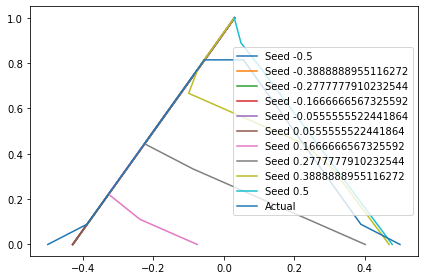

In [39]:
%matplotlib inline
for _ in range(100):
    for _ in range(50):
        iterate()
    iterate(True)

In [7]:
import matplotlib
% pylab
import matplotlib.pyplot as plt

set_matplotlib_colors(matplotlib)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

m_difficulties, m_x = np.meshgrid(x, difficulties)
m_reshaped = generated_states.reshape((difficulties.shape[0], -1)).numpy()

print(m_reshaped)

surf = ax.plot_surface(m_x, m_difficulties, m_reshaped, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel("Difficulty")
ax.set_ylabel("x")
ax.set_zlabel("x")
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

UsageError: Line magic function `%` not found.


In [ ]:
% matplotlib inline
# %pylab
fig, axs = plt.subplots()

for i in range(15):
    selected = generated_states[i * 10:(i + 1) * 10].flatten()
    print(difficulties)
    print(oracle(selected))
    print(F.mse_loss(difficulties, oracle(selected)))
    print()
    axs.plot(selected, difficulties)

axs.legend([f"seed = {x1}" for x1 in x])
plt.tight_layout()
plt.show()